In [36]:
import pandas as pd
import numpy as np

In [37]:
df = pd.read_csv('sales.csv')
df.head()

,Unnamed: 0,store_ID,day_of_week,date,nb_customers_on_day,open,promotion,state_holiday,school_holiday,sales
0,425390,366,4,2013-04-18,517,1,0,0,0,4422
1,291687,394,6,2015-04-11,694,1,0,0,0,8297
2,411278,807,4,2013-08-29,970,1,1,0,0,9729
3,664714,802,2,2013-05-28,473,1,1,0,0,6513
4,540835,726,4,2013-10-10,1068,1,1,0,0,10882


In [38]:
print(df.isnull().sum())


Unnamed: 0             0
store_ID               0
day_of_week            0
date                   0
nb_customers_on_day    0
open                   0
promotion              0
state_holiday          0
school_holiday         0
sales                  0
dtype: int64


In [39]:
print(df.dtypes)

Unnamed: 0              int64
store_ID                int64
day_of_week             int64
date                   object
nb_customers_on_day     int64
open                    int64
promotion               int64
state_holiday          object
school_holiday          int64
sales                   int64
dtype: object


In [ ]:
#df = df.drop('sales', axis=1)
#print(df.dtypes)

In [40]:
df = df.drop(['state_holiday', 'date'], axis=1)
print(df.dtypes)

Unnamed: 0             int64
store_ID               int64
day_of_week            int64
nb_customers_on_day    int64
open                   int64
promotion              int64
school_holiday         int64
sales                  int64
dtype: object


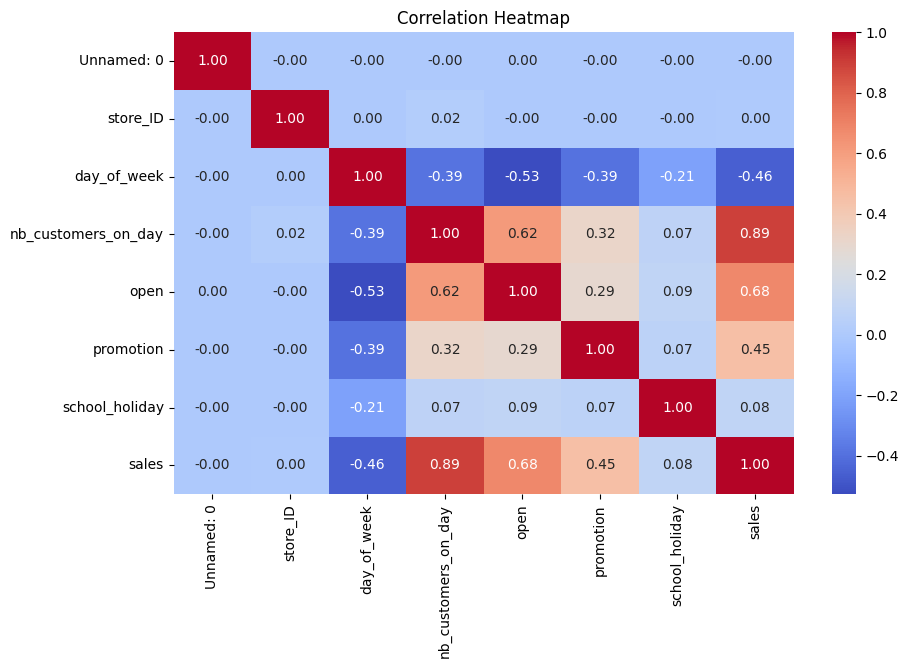

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [41]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()

In [45]:
from sklearn.model_selection import train_test_split

X_train = df.drop('sales', axis=1)
y_train = df['sales']
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
model.fit(X_train, y_train)

(512672, 7)
(128168, 7)
(512672,)
(128168,)


LinearRegression()

In [48]:
from sklearn.metrics import r2_score
y_pred = model.predict(X_test)
print(y_pred[:5])

#R-Squared score
r2_train = model.score(X_train, y_train)
print("R-squared score (train):", r2_train)
r2 = r2_score(y_test, y_pred)
print("R-squared score (test):", r2)


[9676.12969142 -166.81726388 5236.59917109 5498.22736724 5868.82825945]
R-squared score (train): 0.8527791682083496
R-squared score (test): 0.8500734963971117


Observations:
